## Implementing RNN

#### Table of Contents:
* [RNN from scratch](#scratch)
* [RNN Pytorch](#rnn)

In [2]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

### Pros and Cons of RNN
**Pros**:<br>
- Possibility of processing input of any length
- Model size doesn't increase with the size of inputs
- Computation takes into account historical information
- Weights are shared across time

**Cons**:<br>
- Computation is slow
- Difficulty to access information from a long time ago
- Inability to consider any future input for the current state


### RNN from scratch <a class="anchor" id="scratch"/>

This part is taken from a tutorial by <a href="https://www.youtube.com/watch?v=WEV61GmmPrk&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=19">Python Engineer "Name classification using RNN"</a>.
The case that will be demonstrated is name classification.

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_to_output = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.input_to_hidden(combined)
        output = self.input_to_output(combined)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [4]:
# one step
input_tensor = letter_to_tensor('A')
# print(input_tensor.shape, input_tensor)

hidden_tensor = rnn.init_hidden()
# print(hidden_tensor.shape, hidden_tensor)

In [5]:
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
# print(output)
# print(next_hidden)

In [6]:
def category_from_output(output):
    category_index = torch.argmax(output).item()
    return all_categories[category_index]

category_from_output(output)

'Vietnamese'

In [18]:
criterion = nn.NLLLoss()
lr = 0.005
optimizer = optim.SGD(rnn.parameters(), lr=lr)


In [24]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for idx in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[idx], hidden)

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 1.5095 Deighton / Scottish WRONG (English)
10000 10.0 0.1427 Dubhain / Irish CORRECT
15000 15.0 1.1401 Michael / Irish CORRECT
20000 20.0 4.0577 Whitmire / Scottish WRONG (Czech)
25000 25.0 0.0409 Callaghan / Irish CORRECT
30000 30.0 2.2182 Samuel / Arabic WRONG (French)
35000 35.0 0.7920 Issa / Arabic CORRECT
40000 40.0 0.0583 Jong / Korean CORRECT
45000 45.0 0.8157 Westerberg / German CORRECT
50000 50.0 0.9206 Hong / Korean WRONG (Chinese)
55000 55.00000000000001 2.9969 Mccormack / Czech WRONG (English)
60000 60.0 3.1835 Sappe / Dutch WRONG (Czech)
65000 65.0 0.0504 Phung / Vietnamese CORRECT
70000 70.0 0.0330 Ishida / Japanese CORRECT
75000 75.0 0.3103 Saliba / Arabic CORRECT
80000 80.0 1.8155 Snider / German WRONG (Dutch)
85000 85.0 1.5660 Tailler / Scottish WRONG (French)
90000 90.0 0.6237 Araullo / Portuguese CORRECT
95000 95.0 0.0535 Hayuata / Japanese CORRECT
100000 100.0 0.1423 Gu / Korean CORRECT


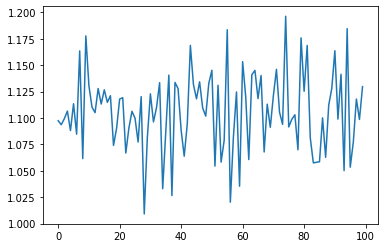

In [26]:
plt.figure()
plt.plot(all_losses)
plt.show()


In [7]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)


Input:Williams

> Williams
Vietnamese
Input:quit
